In [1]:
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import gym

env = gym.make('SuperMarioBros-v0', apply_api_compatibility=True, render_mode="human")
env = JoypadSpace(env, SIMPLE_MOVEMENT)

C:\Users\debdi\anaconda3\Lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
C:\Users\debdi\anaconda3\Lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


In [2]:
done = True
env.reset()
for step in range(5000):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    if done:
       state = env.reset()

env.close()

C:\Users\debdi\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\Users\debdi\anaconda3\Lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


In [2]:
state = env.reset()

In [3]:
state[0].shape

(240, 256, 3)

In [4]:
# Import Frame Stack Wrapper and Gray Scale Wrapper
from gym.wrappers import FrameStack, GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# import matplotlib to show the impact of frame stacking
from matplotlib import pyplot as plt

C:\Users\debdi\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


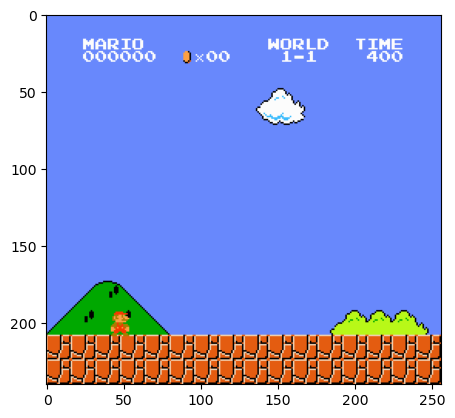

In [5]:
plt.imshow(state[0])

In [6]:
JoypadSpace.reset = lambda self, **kwargs: self.env.reset(**kwargs)

In [7]:
# Add GrayScale to image to minimize the information from colors
env = GrayScaleObservation(env, keep_dim=True)
# Wrap inside the Dummy environment
env = DummyVecEnv([lambda: env])

C:\Users\debdi\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [8]:
# Stack the frames
env = VecFrameStack(env, 4, channels_order="last")

In [9]:
state = env.reset()

In [10]:
state.shape

(1, 240, 256, 4)

In [48]:
for _ in range(4):
    action = env.action_space.sample()
    obs, reward, terminated, info = env.step([action])
print(obs.shape)  # Should still be (1, 240, 256, 4)


(1, 240, 256, 4)


In [49]:
print(obs[0][:, :, 2])

[[140 140 140 ... 140 140 140]
 [140 140 140 ... 140 140 140]
 [140 140 140 ... 140 140 140]
 ...
 [214 124 124 ... 124 124   0]
 [214 124 124 ... 124   0   0]
 [124   0   0 ...   0   0 124]]


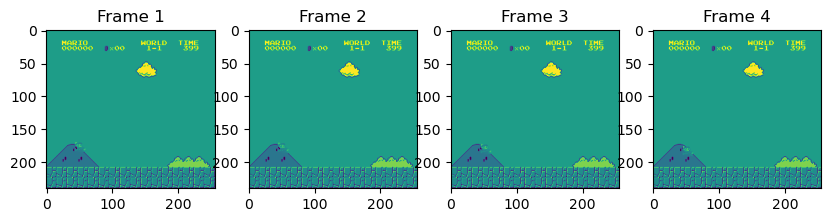

In [50]:
plt.figure(figsize=(10, 8))
for idx in range(state.shape[3]):
    plt.subplot(1, 4, idx + 1)
    plt.imshow(obs[0][:, :, idx])
    plt.title(f"Frame {idx+1}")
plt.show()

# Train the model

In [52]:
# Import os for file path management
import os
# Import PPO for algos
from stable_baselines3 import PPO
# import base callbacks for model saving
from stable_baselines3.common.callbacks import BaseCallback

In [53]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
    
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
            
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, "best_model_{}".format(self.n_calls))
            self.model.save(model_path)
            
        return True

In [55]:
CHECKPOINT_DIR = "./train/"
LOG_DIR = "./logs/"

In [62]:
callback = TrainAndLoggingCallback(check_freq=5000, save_path=CHECKPOINT_DIR)

In [63]:
# Initializing the AI model

model = PPO("CnnPolicy", env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, n_steps=512)


Using cpu device
Wrapping the env in a VecTransposeImage.


In [64]:
# Doing some training
model.learn(total_timesteps=50000, callback=callback)

Logging to ./logs/PPO_2
----------------------------
| time/              |     |
|    fps             | 76  |
|    iterations      | 1   |
|    time_elapsed    | 6   |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 15            |
|    iterations           | 2             |
|    time_elapsed         | 64            |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 4.9248687e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | 0.00383       |
|    learning_rate        | 1e-06         |
|    loss                 | 187           |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000524     |
|    value_loss           | 486           |
-------------------------

-------------------------------------------
| time/                   |               |
|    fps                  | 9             |
|    iterations           | 13            |
|    time_elapsed         | 671           |
|    total_timesteps      | 6656          |
| train/                  |               |
|    approx_kl            | 2.0574429e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | -0.00253      |
|    learning_rate        | 1e-06         |
|    loss                 | 0.116         |
|    n_updates            | 120           |
|    policy_gradient_loss | -0.000282     |
|    value_loss           | 0.306         |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 9             |
|    iterations           | 14            |
|    time_elapsed         | 728 

-----------------------------------------
| time/                   |             |
|    fps                  | 9           |
|    iterations           | 24          |
|    time_elapsed         | 1324        |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 8.57655e-06 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.94       |
|    explained_variance   | -0.0125     |
|    learning_rate        | 1e-06       |
|    loss                 | 0.25        |
|    n_updates            | 230         |
|    policy_gradient_loss | -8.58e-05   |
|    value_loss           | 0.487       |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 9             |
|    iterations           | 25            |
|    time_elapsed         | 1389          |
|    total_timesteps    

-------------------------------------------
| time/                   |               |
|    fps                  | 9             |
|    iterations           | 35            |
|    time_elapsed         | 1953          |
|    total_timesteps      | 17920         |
| train/                  |               |
|    approx_kl            | 1.0480173e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.94         |
|    explained_variance   | 0.0793        |
|    learning_rate        | 1e-06         |
|    loss                 | 20.9          |
|    n_updates            | 340           |
|    policy_gradient_loss | 0.000124      |
|    value_loss           | 33.4          |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 9             |
|    iterations           | 36            |
|    time_elapsed         | 2007

-------------------------------------------
| time/                   |               |
|    fps                  | 9             |
|    iterations           | 46            |
|    time_elapsed         | 2563          |
|    total_timesteps      | 23552         |
| train/                  |               |
|    approx_kl            | 1.8353923e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.93         |
|    explained_variance   | -0.053        |
|    learning_rate        | 1e-06         |
|    loss                 | 0.073         |
|    n_updates            | 450           |
|    policy_gradient_loss | -0.000178     |
|    value_loss           | 0.219         |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 9             |
|    iterations           | 47            |
|    time_elapsed         | 2618

-------------------------------------------
| time/                   |               |
|    fps                  | 9             |
|    iterations           | 57            |
|    time_elapsed         | 3164          |
|    total_timesteps      | 29184         |
| train/                  |               |
|    approx_kl            | 2.5173882e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.93         |
|    explained_variance   | -0.0103       |
|    learning_rate        | 1e-06         |
|    loss                 | 0.172         |
|    n_updates            | 560           |
|    policy_gradient_loss | 3.44e-05      |
|    value_loss           | 0.455         |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 9             |
|    iterations           | 58            |
|    time_elapsed         | 3219

-------------------------------------------
| time/                   |               |
|    fps                  | 9             |
|    iterations           | 68            |
|    time_elapsed         | 3769          |
|    total_timesteps      | 34816         |
| train/                  |               |
|    approx_kl            | 0.00026676978 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.91         |
|    explained_variance   | 0.118         |
|    learning_rate        | 1e-06         |
|    loss                 | 125           |
|    n_updates            | 670           |
|    policy_gradient_loss | 0.000994      |
|    value_loss           | 172           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 9             |
|    iterations           | 69            |
|    time_elapsed         | 3823

-------------------------------------------
| time/                   |               |
|    fps                  | 9             |
|    iterations           | 79            |
|    time_elapsed         | 4371          |
|    total_timesteps      | 40448         |
| train/                  |               |
|    approx_kl            | 6.8142195e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.92         |
|    explained_variance   | 0.0111        |
|    learning_rate        | 1e-06         |
|    loss                 | 0.0783        |
|    n_updates            | 780           |
|    policy_gradient_loss | -0.000617     |
|    value_loss           | 0.151         |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 9             |
|    iterations           | 80            |
|    time_elapsed         | 4426

------------------------------------------
| time/                   |              |
|    fps                  | 9            |
|    iterations           | 90           |
|    time_elapsed         | 4976         |
|    total_timesteps      | 46080        |
| train/                  |              |
|    approx_kl            | 7.046654e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.91        |
|    explained_variance   | 0.107        |
|    learning_rate        | 1e-06        |
|    loss                 | 0.111        |
|    n_updates            | 890          |
|    policy_gradient_loss | -0.000497    |
|    value_loss           | 0.356        |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 9             |
|    iterations           | 91            |
|    time_elapsed         | 5032          |
|    t

# Testing

In [80]:
model = PPO.load("./train/best_model_50000.zip")

In [81]:
state = env.reset()

In [82]:
SIMPLE_MOVEMENT[model.predict(state)[0][0]]

['A']

In [83]:
# Start the game
aaastate = env.reset()

while True:
    action, _state = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

KeyboardInterrupt: 

In [84]:
env.close()